In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

import torch

# need to import classes in order for torch.load to work
from latent_geometry.model.mnist_vae import (
    load_decoder,
    load_encoder,
)
from latent_geometry.mapping import TorchModelMapping, Mapping
from latent_geometry.visual.plotly import (
    create_topology_fig,
)
from latent_geometry.manifold import LatentManifold
from latent_geometry.metric import EuclideanMetric, PullbackMetric
from latent_geometry.path import ManifoldPath
from latent_geometry.data import load_mnist_dataset
from latent_geometry.utils import project, lift
import os

from typing import Union, Callable, Optional

from scipy.interpolate import splev, splprep
from functools import partial

In [4]:
# raise Exception("double check that we wont use already taken gpu ($ nvidia-smi)")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [5]:
dataset = load_mnist_dataset(split="train")
img, label = dataset[0]
print(img.shape, label)

torch.Size([1, 32, 32]) 5


In [6]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda")

ENCODER = load_encoder(DEVICE, "encoder.pt")
DECODER = load_decoder(DEVICE, "decoder.pt")

z = ENCODER.sample(dataset[0][0].to(DEVICE)[None, :])
reconstruction = DECODER(z)
reconstruction.shape

torch.Size([1, 1, 32, 32])

In [7]:
SOLVER_TOL = 0.1

In [8]:
ambient_metric = EuclideanMetric(1024)
latent_mapping = TorchModelMapping(DECODER, (2,), (1, 32, 32), batch_size=10_000)
manifold_mnist = LatentManifold(
    latent_mapping, ambient_metric, solver_tol=SOLVER_TOL, bvp_n_mesh_nodes=1_000
)

In [9]:
def create_straight_path(
    from_: np.ndarray, to_: np.ndarray, manifold: LatentManifold
) -> ManifoldPath:
    def x_fun(t: float) -> np.ndarray:
        return from_ + (to_ - from_) * t

    def v_fun(t: float) -> np.ndarray:
        return from_ - to_

    return ManifoldPath(
        x_fun, v_fun, manifold.metric, manifold._euclidean_latent_metric
    )


def create_latent_path(from_: np.ndarray, theta: float, length: float) -> ManifoldPath:
    return manifold_mnist.path_given_direction(
        from_, np.array([np.cos(theta), np.sin(theta)]), length
    )


def create_geodesic_path(from_: np.ndarray, to_: np.ndarray) -> ManifoldPath:
    return manifold_mnist.geodesic(from_, to_)

In [10]:
def calc_ambient_dist(
    path: ManifoldPath,
    mapping: Mapping,
    t_start: float,
    t_end: float,
    n_points: int = 1_000,
) -> float:
    ts = np.linspace(t_start, t_end, n_points)
    xs_latent = lift(path)(ts)
    xs_ambient = mapping(xs_latent)
    diffs = xs_ambient[1:] - xs_ambient[:-1]
    length = np.sqrt((diffs**2).sum(axis=1)).sum(axis=0)
    return length

In [11]:
def eval_path(t: float, tck: tuple) -> np.ndarray:
    x, y = splev(t, tck)
    return np.hstack([x, y])

In [12]:
def create_path_from_points(
    xs: np.ndarray, manifold: LatentManifold
) -> ManifoldPath:  # TODO: velo does not work
    tck, u = splprep(xs.T, s=0, per=0)
    path_fun = partial(eval_path, tck=tck)
    return ManifoldPath(
        x_fun=path_fun,
        v_fun=None,
        manifold_metric=manifold.metric,
        euclidean_metric=manifold._euclidean_latent_metric,
    )

In [13]:
def show_path_in_ambient(path: ManifoldPath, n_points: int = 9):
    fig, axes = plt.subplots(1, n_points, figsize=(1.5 * n_points, 2))
    for i in range(n_points):
        t = i / (n_points - 1)
        latent_dist = path.manifold_length(0, t)
        euclidean_dist = path.euclidean_length(0, t)
        # latent_dist_diff = path.manifold_length_diff(0, t)
        # euclidean_dist_diff = path.euclidean_length_diff(0, t)

        ambient_dist = calc_ambient_dist(path, latent_mapping, 0, t)

        image = project(latent_mapping)(path(t)).reshape((32, 32))
        ax = axes[i]
        ax.imshow(image, cmap="gray")
        ax.set_title(
            (
                f"v: Euc: {euclidean_dist:.3f}, P-B: {latent_dist: .3f}\n"
                # f"d: Euc: {euclidean_dist_diff:.3f}, P-B: {latent_dist_diff: .3f}\n"
                f"ambient dist: {ambient_dist:.3f}"
            ),
            fontsize=8,
        )
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

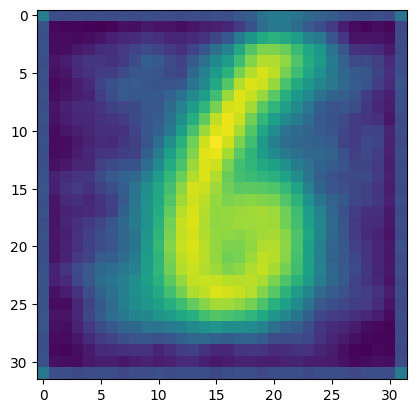

In [14]:
START = np.array([1.0, 1])
plt.imshow(project(latent_mapping)(START).reshape(32, 32))

In [15]:
latent_path = create_latent_path(START, np.pi * 0.9, 10.0)
straight_path = create_straight_path(latent_path(0), latent_path(1), manifold_mnist)

In [16]:
END = latent_path(1)
VEC = END - START
ANGLE_STRAIGHT = np.arctan2(VEC[1], VEC[0])
latent_path2 = create_latent_path(START, ANGLE_STRAIGHT, 10.0)

In [17]:
ANGLE_STRAIGHT, np.pi * 0.9

(2.7277347240494927, 2.827433388230814)

In [18]:
straight_path(0), straight_path(1)
# latent_path(0), latent_path(1)
# geodesic(0), geodesic(1)

(array([1., 1.]), array([0.94484954, 1.0242235 ]))

In [19]:
geodesic = create_geodesic_path(latent_path(0), latent_path(1))

In [20]:
def plot_paths(
    paths: list[tuple[ManifoldPath, str]],
    ts: np.ndarray = np.linspace(0, 1),
):
    for path, name in paths:
        path_pts = lift(path)(ts)
        plt.plot(path_pts[:, 0], path_pts[:, 1], label=name)

    plt.legend()


def plot_accelerations(
    paths: list[tuple[ManifoldPath, str]],
    scale: float,
    num: int = 20,
    dt: float = 0.001,
):
    for path, name in paths:
        for t in np.linspace(0, 1 - dt, num=num):
            x, x2 = path(t), path(t + dt)
            v = (x2 - x) / dt
            acc = (
                project(path._manifold_metric.acceleration)(position=x, velocity=v)
                * scale
            )
            plt.arrow(x[0], x[1], acc[0], acc[1])

In [21]:
def interpolate_paths(
    path_a, path_b, n: int, ts: np.ndarray = np.linspace(0, 1)
) -> list[np.ndarray]:
    results = []
    for i in range(1, n + 1):
        lam = i / (n + 1)
        path = lift(path_a)(ts) * lam + lift(path_b)(ts) * (1 - lam)
        path_fun = create_path_from_points(path, manifold_mnist)
        results.append(path_fun)
    return results

In [22]:
N_PATHS = 4
IMP_PATHS = [
    (straight_path, "straight"),
    (geodesic, "geodesic"),
    (latent_path2, "latent2"),
]
INTER_PATHS = [
    (path, f"path_{i}")
    for i, path in enumerate(interpolate_paths(geodesic, straight_path, n=N_PATHS))
]
ALL_PATHS = IMP_PATHS + [(latent_path, "latent")] + INTER_PATHS

In [23]:
ANGLES = np.linspace(np.pi * 1, np.pi * 0.8, 8)
SPIDER_PATHS = [
    (create_latent_path(START, theta, 10.0), f"spider_{i}")
    for i, theta in enumerate(ANGLES)
]

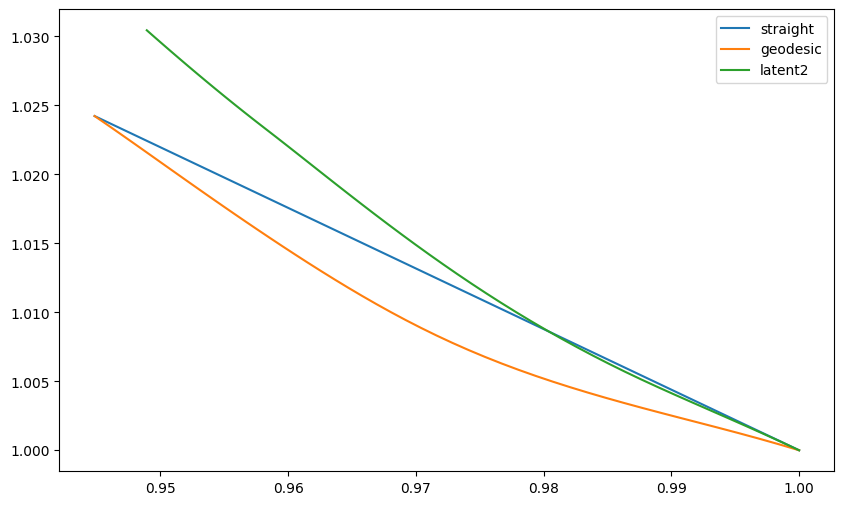

In [24]:
plt.figure(figsize=(10, 6))
plot_paths(IMP_PATHS)
# plot_accelerations(ALL_PATHS, scale=0.015, num=20, dt=0.001)
plt.show()

['straight', 'geodesic', 'latent2']


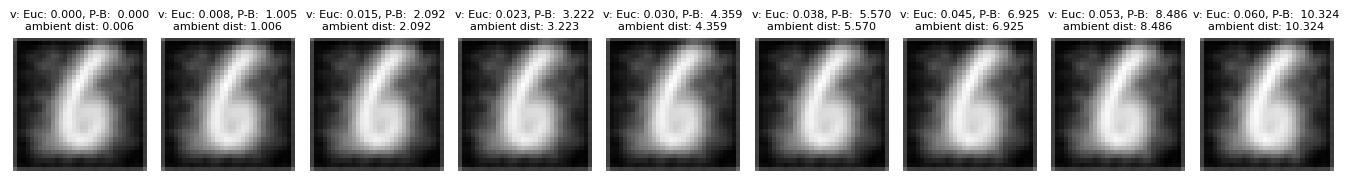

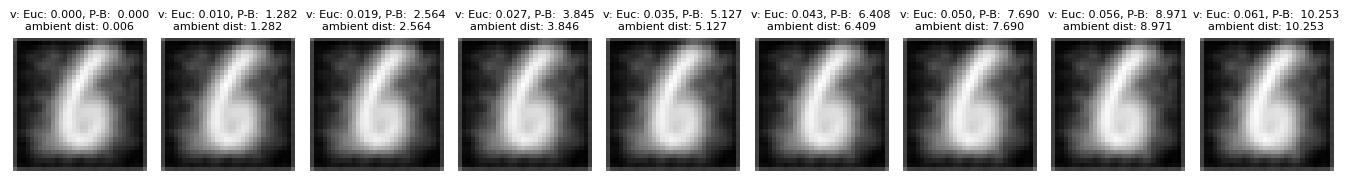

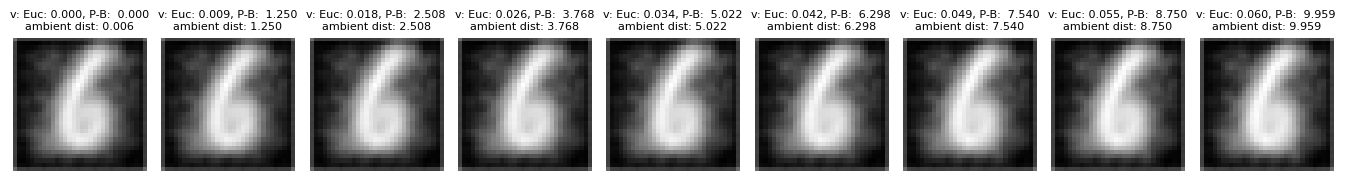

In [25]:
# pths = [(straight_path, "straight")] + SPIDER_PATHS
pths = IMP_PATHS
print([name for _, name in pths])
for path, name in pths:
    show_path_in_ambient(path, n_points=9)